In [1]:
import pandas as pd

## Data loading and preprocessing

In [2]:
data = pd.read_csv('./medDataset_processed.csv')
data.head()

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


In [3]:
import re, string 
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

clean = lambda x: clean_text(x)

data['Question'] = data.Question.apply(clean)
data['Answer'] = data.Answer.apply(clean)
data.dropna(inplace=True)
data.drop_duplicates(subset=['Question'], inplace=True)
data.head()

,qtype,Question,Answer
0,susceptibility,who is at risk for lymphocytic choriomeningiti...,lcmv infections can occur after exposure to fr...
1,symptoms,what are the symptoms of lymphocytic choriomen...,lcmv is most commonly recognized as causing ne...
3,exams and tests,how to diagnose lymphocytic choriomeningitis lcm,during the first phase of the disease the most...
4,treatment,what are the treatments for lymphocytic chorio...,aseptic meningitis encephalitis or meningoence...
5,prevention,how to prevent lymphocytic choriomeningitis lcm,lcmv infection can be prevented by avoiding co...


## EDA

<Axes: xlabel='qtype'>

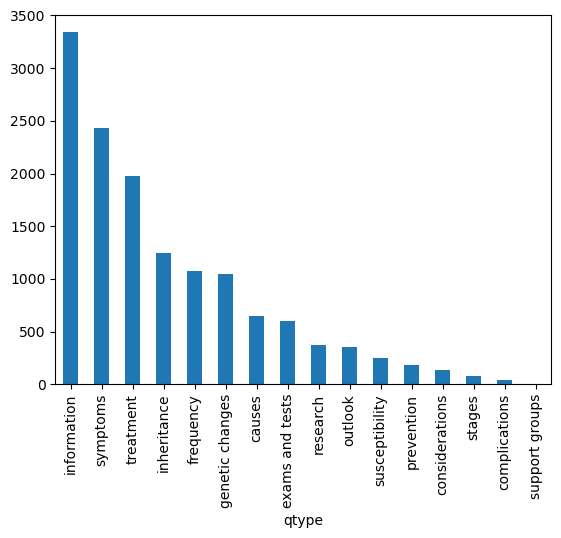

In [4]:
# find no of questions for each qtype and plot a bar graph
data['qtype'].value_counts().plot(kind='bar')

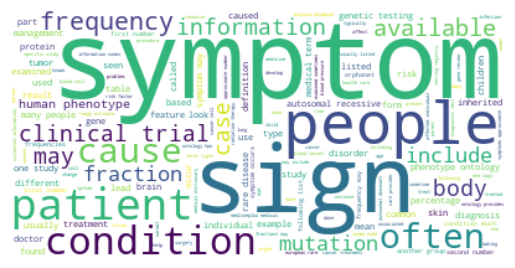

In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
stopwords.update(["br", "href", "target", "http", "www", "com", "org", "net", "co", "uk", "de", "ca", "us", "en", "fr", "jp", "it", "es", "nl", "se", "ru", "ch", "no", "at", "dk", "au", "gr", "ie", "nz", "be", "pl", "hu", "ro", "cz", "eu", "tv", "me", "edu"
])

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(" ".join([i for i in data.Answer]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Split into train, test and validation

In [4]:
# split into train, validation and test sets

train = data.sample(frac=0.7, random_state=0)
validation = data.drop(train.index)
test = validation.sample(frac=0.5, random_state=0)
validation = validation.drop(test.index)

print(train.shape)
print(validation.shape)
print(test.shape)

train.to_csv('./train.csv', index=False)
validation.to_csv('./validation.csv', index=False)
test.to_csv('./test.csv', index=False)

(9634, 3)
(2065, 3)
(2064, 3)


## Creating dataset class 

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import AutoTokenizer 

class MedDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.question = data.Question
        self.answer = data.Answer
        self.max_length = max_length

    def __len__(self):
        return len(self.question)

    def __getitem__(self, index):
        question = str(self.question.iloc[index])
        question = " ".join(question.split())

        answer = str(self.answer.iloc[index])
        answer = " ".join(answer.split())

        # input is the question, target is the answer
        inputs = self.tokenizer(
            question,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
        )

        targets = self.tokenizer(
            answer,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
        )

        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long).flatten(),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long).flatten(),
            'target_ids': torch.tensor(targets['input_ids'], dtype=torch.long).flatten(),
        }

/home2/ankith_varun/miniconda3/envs/rohan/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define Model & Tokenizer

In [6]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-small')
model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-small')
max_length = model.config.n_positions
train_dataset = MedDataset(train, tokenizer, max_length)
validation_dataset = MedDataset(validation, tokenizer, max_length)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=True`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [7]:
from torch import cuda 
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


## Define Hyperparameters

In [8]:
BATCH_SIZE = 4
EPOCHS = 15
LEARNING_RATE = 1e-05

In [9]:
# free CUDA memory
torch.cuda.empty_cache()

In [10]:
from typing import Any
import numpy as np
class EarlyStopping:
    def __init__(self, patience=5, delta=0.1):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss):
        score = val_loss
        
        if self.best_score is None:
            self.best_score = score
        elif score > self.best_score + self.delta:
            self.counter += 1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

## Fine-tune the model

In [11]:
from tqdm import tqdm
def train_model():
    model.to(device)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
    es = EarlyStopping(patience=2, delta=0.1)

    for epoch in range(EPOCHS):
        
        model.train()
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        avg_loss = 0
        for i, data in pbar:
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            targets = data['target_ids'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            pbar.set_description(f'Batch: {i+1}, Loss:  {loss.item()}')

        print(f'Epoch: {epoch}, Train Loss:  {avg_loss/len(train_loader)}')

        pbar = tqdm(enumerate(validation_loader), total=len(validation_loader))
        avg_loss = 0

        model.eval()
        with torch.no_grad():
            for i, data in pbar:
                ids = data['input_ids'].to(device, dtype = torch.long)
                mask = data['attention_mask'].to(device, dtype = torch.long)
                targets = data['target_ids'].to(device, dtype = torch.long)

                outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
                loss = outputs.loss
                avg_loss += loss.item()
                pbar.set_description(f'Batch: {i+1}, Loss:  {loss.item()}')
        
        print(f'Epoch: {epoch}, Validation Loss:  {avg_loss/len(validation_loader)}')

        es(avg_loss/len(validation_loader))
        if es.early_stop:
            print("Early stopping")
            break

In [12]:
train_model()

Batch: 2409, Loss:  2.6311843395233154: 100%|██████████| 2409/2409 [09:54<00:00,  4.05it/s] 


Epoch: 0, Train Loss:  3.908288407469251


Batch: 517, Loss:  1.1479653120040894: 100%|██████████| 517/517 [00:42<00:00, 12.18it/s] 


Epoch: 0, Validation Loss:  1.4005087506263814


Batch: 2409, Loss:  0.8130111694335938: 100%|██████████| 2409/2409 [09:54<00:00,  4.05it/s] 


Epoch: 1, Train Loss:  1.4878080044113386


Batch: 517, Loss:  1.0225391387939453: 100%|██████████| 517/517 [00:42<00:00, 12.18it/s] 


Epoch: 1, Validation Loss:  1.1654722630055314


Batch: 2409, Loss:  1.0551403760910034: 100%|██████████| 2409/2409 [09:54<00:00,  4.05it/s] 


Epoch: 2, Train Loss:  1.2735204072711674


Batch: 517, Loss:  3.029956340789795: 100%|██████████| 517/517 [00:42<00:00, 12.21it/s]  


Epoch: 2, Validation Loss:  1.0758204881526976


Batch: 2409, Loss:  0.43407273292541504: 100%|██████████| 2409/2409 [09:54<00:00,  4.05it/s]


Epoch: 3, Train Loss:  1.1795562007160987


Batch: 517, Loss:  1.1549196243286133: 100%|██████████| 517/517 [00:42<00:00, 12.11it/s] 


Epoch: 3, Validation Loss:  1.0313976051959586


Batch: 2409, Loss:  1.011589527130127: 100%|██████████| 2409/2409 [09:54<00:00,  4.05it/s]  


Epoch: 4, Train Loss:  1.1331171738242847


Batch: 517, Loss:  1.1085091829299927: 100%|██████████| 517/517 [00:42<00:00, 12.17it/s] 


Epoch: 4, Validation Loss:  1.004259907415342


Batch: 2409, Loss:  1.4456359148025513: 100%|██████████| 2409/2409 [09:53<00:00,  4.06it/s] 


Epoch: 5, Train Loss:  1.1023510919876889


Batch: 517, Loss:  0.16666807234287262: 100%|██████████| 517/517 [00:42<00:00, 12.13it/s]


Epoch: 5, Validation Loss:  0.9821302193564649


Batch: 2409, Loss:  1.4754034280776978: 100%|██████████| 2409/2409 [09:55<00:00,  4.04it/s] 


Epoch: 6, Train Loss:  1.0795493929922555


Batch: 517, Loss:  1.0428544282913208: 100%|██████████| 517/517 [00:42<00:00, 12.23it/s] 


Epoch: 6, Validation Loss:  0.967755388187486


Batch: 2409, Loss:  1.0872015953063965: 100%|██████████| 2409/2409 [09:55<00:00,  4.05it/s] 


Epoch: 7, Train Loss:  1.0613829363191607


Batch: 517, Loss:  0.41447365283966064: 100%|██████████| 517/517 [00:42<00:00, 12.18it/s]


Epoch: 7, Validation Loss:  0.9529671596518107


Batch: 2409, Loss:  1.1244884729385376: 100%|██████████| 2409/2409 [09:54<00:00,  4.05it/s] 


Epoch: 8, Train Loss:  1.045288602789441


Batch: 517, Loss:  0.8146439790725708: 100%|██████████| 517/517 [00:42<00:00, 12.16it/s] 


Epoch: 8, Validation Loss:  0.9422587671927833


Batch: 2409, Loss:  0.40736451745033264: 100%|██████████| 2409/2409 [09:54<00:00,  4.05it/s]


Epoch: 9, Train Loss:  1.0318529390482152


Batch: 517, Loss:  0.3144497871398926: 100%|██████████| 517/517 [00:42<00:00, 12.17it/s] 


Epoch: 9, Validation Loss:  0.9314799577689493


Batch: 2409, Loss:  0.8122521638870239: 100%|██████████| 2409/2409 [09:53<00:00,  4.06it/s] 


Epoch: 10, Train Loss:  1.0196474295073943


Batch: 517, Loss:  0.23009730875492096: 100%|██████████| 517/517 [00:42<00:00, 12.16it/s]


Epoch: 10, Validation Loss:  0.921977780716101


Batch: 2409, Loss:  0.29546409845352173: 100%|██████████| 2409/2409 [09:53<00:00,  4.06it/s]


Epoch: 11, Train Loss:  1.0094113800614366


Batch: 517, Loss:  0.12210205942392349: 100%|██████████| 517/517 [00:42<00:00, 12.21it/s]


Epoch: 11, Validation Loss:  0.9132937611849903


Batch: 2409, Loss:  0.951241672039032: 100%|██████████| 2409/2409 [09:54<00:00,  4.05it/s]  


Epoch: 12, Train Loss:  0.9993755386430181


Batch: 517, Loss:  0.5576774477958679: 100%|██████████| 517/517 [00:42<00:00, 12.21it/s] 


Epoch: 12, Validation Loss:  0.905975331766693


Batch: 2409, Loss:  1.4285361766815186: 100%|██████████| 2409/2409 [09:53<00:00,  4.06it/s] 


Epoch: 13, Train Loss:  0.990670599114504


Batch: 517, Loss:  0.26068490743637085: 100%|██████████| 517/517 [00:42<00:00, 12.18it/s] 


Epoch: 13, Validation Loss:  0.8991359241191492


Batch: 2409, Loss:  0.325295090675354: 100%|██████████| 2409/2409 [09:53<00:00,  4.06it/s]   


Epoch: 14, Train Loss:  0.9816377422203657


Batch: 517, Loss:  0.34582164883613586: 100%|██████████| 517/517 [00:42<00:00, 12.19it/s] 

Epoch: 14, Validation Loss:  0.8932873532536297


In [13]:
# save the model and tokenizer
model.save_pretrained('./model')

## Inference 

In [14]:
# inference
def inference(question):
    model.eval()
    question = " ".join(question.split())
    inputs = tokenizer.encode_plus(question, max_length=max_length, padding='max_length', truncation=True, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=100)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

question = 'what are the treatments for kabuki syndrome?'
answer = inference(question)
print(f'Question: {question}')
print(f'Answer: {answer}')

Question: what are the treatments for kabuki syndrome?
Answer: these resources address the diagnosis or management of kabuki syndrome gene review gene review kabuki syndrome genetic testing registry kabuki syndrome genetic testing registry kabuki syndrome genetic testing registry kabuki syndrome genetic testing registry kabuki syndrome genetic testing registry kabuki syndrome genetic testing registry kabuki syndrome genetic testing registry kabuki syndrome genetic testing registry kabuki syndrome genetic testing registry kabuki syndrome genetic testing registry ka


In [15]:
test = pd.read_csv('./test.csv')
test.head()

,qtype,Question,Answer
0,information,what is are tempi syndrome,tempi syndrome is a newly discovered multisyst...
1,symptoms,what are the symptoms of nocardiosis,the symptoms of nocardiosis vary depending on ...
2,inheritance,is doors syndrome inherited,this condition is inherited in an autosomal re...
3,causes,what causes cri du chat syndrome,what causes cri du chat syndrome cri du chat s...
4,symptoms,what are the symptoms of thrombocythemia and t...,people who have thrombocythemia or thrombocyto...


## Evaluation

In [16]:
# evaluation function

def evaluate(model):
    test_dataset = MedDataset(test, tokenizer, max_length)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    model.eval()
    
    pbar = tqdm(enumerate(test_loader), total=len(test_loader))
    avg_loss = 0

    for i, data in pbar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target_ids'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss = outputs.loss
        avg_loss += loss.item()
        pbar.set_description(f'Batch: {i+1}, Loss:  {loss.item()}')

        # logits = outputs.logits
        # preds = torch.argmax(logits, dim=2)
        # preds = preds.detach().cpu().numpy()
        # targets = targets.detach().cpu().numpy()

    
    print(f'Test Loss:  {avg_loss/len(test_loader)}')

In [17]:
evaluate(model)

Batch: 516, Loss:  0.8489148616790771: 100%|██████████| 516/516 [00:40<00:00, 12.80it/s] 

Test Loss:  0.911940399817256
